In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pystan
from sklearn import preprocessing
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [2]:
df1=pd.read_csv("preprocessed_nikkei.csv")
df1=df1[df1["attendnum"]>=20]
del df1["attendnum"]

df2=pd.read_csv("preprocessed_agc29.csv")
df2=df2[df2["attendnum"]>=20]
del df2["attendnum"]

df3=pd.read_csv("preprocessed_minna.csv")
df3=df3[df3["attendnum"]>=20]
del df3["attendnum"]

In [3]:
df=pd.concat([df1,df2,df3])
df=df.fillna(999) #stanの欠損対策

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
#未提出者の除外
df=df[df.iloc[:,2:].sum(axis=1)>0]

In [6]:
#レートの標準化
#ss = preprocessing.StandardScaler()
#df["OldRating_std"] = ss.fit_transform(np.array(df["OldRating"]).reshape(-1, 1))

#スケール(stan収束のため)
df["OldRating_std"] =df["OldRating"]/1000

In [7]:
#１０(不正解)を0に変換
df.iloc[:,1:-1]=df.iloc[:,1:-1].where(df.iloc[:,1:-1]!=10,0)

In [8]:
df.iloc[:,:-1]=df.iloc[:,:-1].astype(int)

In [10]:
model="""
data {
  int<lower=1> N; // number of data points
  int<lower=1> P; // number of items
  real theta[N]; //normalized rate
  int y[N,P]; // observations
}
 
parameters {
  //real theta[N];
  vector<lower=0>[P] a;
  vector[P] b;
}
 
model {
  #prior
  //theta ~ normal(0,1);
  a ~ cauchy(0,5);
  b ~ normal(0,5);
  
  #model
  for (n in 1:N){
    for(p in 1:P){
      if (y[n,p] != 999){ //欠損処理
          y[n,p] ~ bernoulli_logit(a[p]*(theta[n]-b[p]));
      }
    }
  }
}
"""

In [20]:
data={'N': df.shape[0], 'P':18 ,'y':df.iloc[:,1:19], 'theta':df["OldRating_std"]}
#data={'N': df.shape[0], 'P':6 ,'y':df.iloc[:,2:8], 'theta':df["OldRating"]}

In [21]:
%time fit = pystan.stan(model_code=model, data=data, iter=1000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b54df87abd74a5475fb0be57ce9212e NOW.


CPU times: user 1.42 s, sys: 131 ms, total: 1.55 s
Wall time: 2min 29s


In [22]:
fit

Inference for Stan model: anon_model_0b54df87abd74a5475fb0be57ce9212e.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]    5.26  7.1e-3   0.39   4.57   4.97   5.26   5.51   6.04   2996    1.0
a[2]    3.43  4.9e-3   0.23    3.0   3.27   3.42   3.57   3.91   2125    1.0
a[3]    4.37  8.2e-3   0.38    3.7   4.09   4.36   4.63   5.15   2115    1.0
a[4]    3.62  6.3e-3   0.28   3.07   3.43   3.61   3.81   4.18   1944    1.0
a[5]    3.82    0.01   0.61   2.76   3.39   3.78   4.19   5.12   1809    1.0
a[6]    5.43    0.03   1.22   3.43   4.55   5.33   6.18   8.23   1544    1.0
a[7]    5.37  9.3e-3   0.47   4.48   5.05   5.36   5.69   6.29   2575    1.0
a[8]     5.9    0.01   0.54   4.93    5.5   5.86   6.27   7.01   2628    1.0
a[9]     3.2  4.2e-3   0.22   2.79   3.05    3.2   3.34   3.63   2624    1.0
a[10]   5.87  7.2e-3   0.38   5.16   5.61  

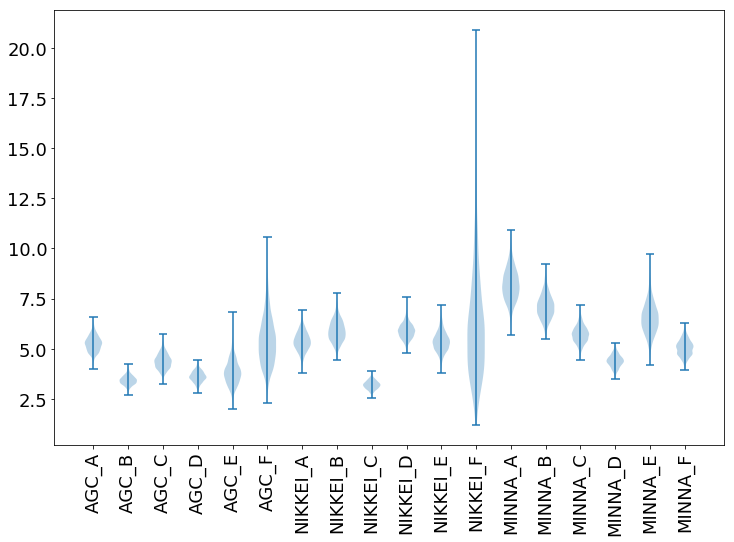

In [44]:
la  = fit.extract(permuted=True)
plt.figure(figsize=(12,8))

cname=["AGC","NIKKEI","MINNA"]
pname=["A","B","C","D","E","F"]
label=[f"{c}_{p}" for c in cname for p in pname]

plt.violinplot([la["a"][:,i] for i in range(18)])
plt.xticks(list(range(1,19)), label)
plt.xticks(rotation=90)
plt.tick_params(labelsize=18)
plt.show()

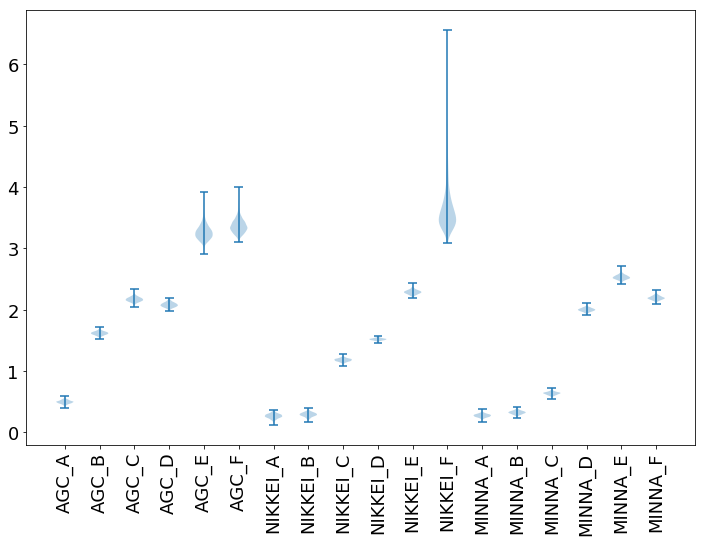

In [45]:
la  = fit.extract(permuted=True)
plt.figure(figsize=(12,8))

cname=["AGC","NIKKEI","MINNA"]
pname=["A","B","C","D","E","F"]
label=[f"{c}_{p}" for c in cname for p in pname]

plt.violinplot([la["b"][:,i] for i in range(18)])
plt.xticks(list(range(1,19)), label)
plt.xticks(rotation=90)
plt.tick_params(labelsize=18)
plt.show()

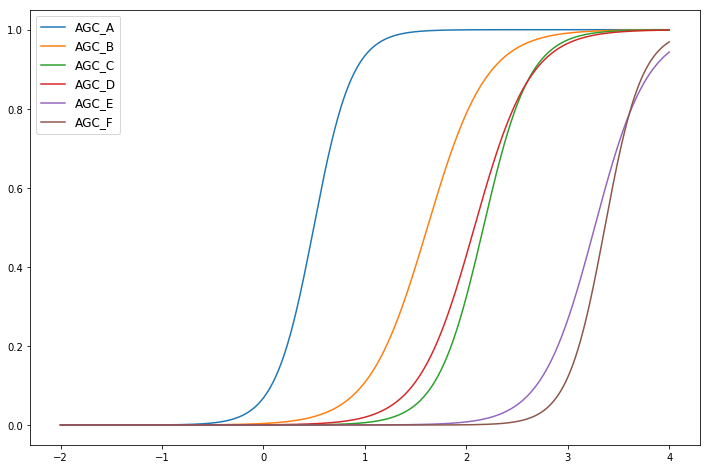

In [52]:
def logistic_function(theta,a,b):
    return 1/(1+np.exp(-a*(theta-b)))
              
theta = np.linspace(-2,4,1000)
name=["A","B","C","D","E","F"]
#theta = np.linspace(-300,300,1000)
plt.figure(figsize=(12,8))
for i,n in zip(range(0,6),name):
    a=la["a"][:,i].mean()
    b=la["b"][:,i].mean()
    plt.plot(theta, logistic_function(theta,a,b),label=f"AGC_{n}")
plt.legend(fontsize=12)
plt.show()

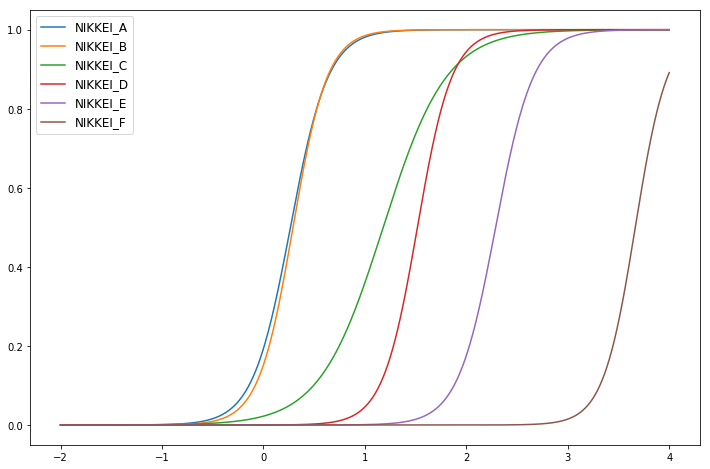

In [53]:
plt.figure(figsize=(12,8))
for i,n in zip(range(6,12),name):
    a=la["a"][:,i].mean()
    b=la["b"][:,i].mean()
    plt.plot(theta, logistic_function(theta,a,b),label=f"NIKKEI_{n}")
plt.legend(fontsize=12)
plt.show()

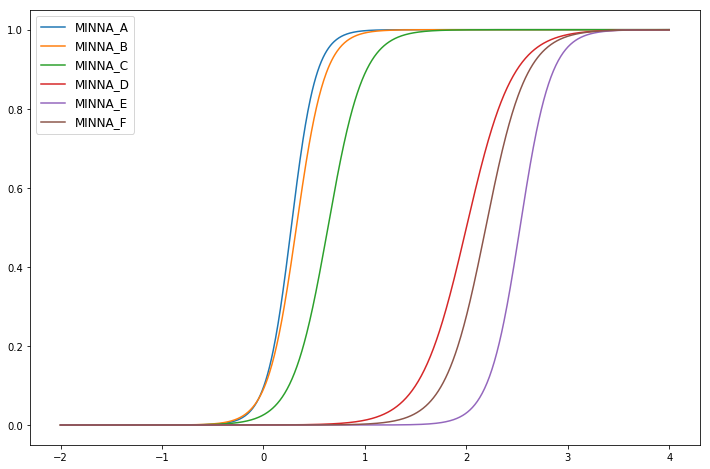

In [54]:
plt.figure(figsize=(12,8))
for i,n in zip(range(12,18),name):
    a=la["a"][:,i].mean()
    b=la["b"][:,i].mean()
    plt.plot(theta, logistic_function(theta,a,b),label=f"MINNA_{n}")
plt.legend(fontsize=12)
plt.show()

In [41]:
#レートを固定した時に各問題を正答する確率
plt.figure(figsize=(12,8))
for i in range(0,18):
    a=la["a"][:,i].mean()
    b=la["b"][:,i].mean()
    print(logistic_function(1.6,a,b))

0.9969992894327204
0.48592715665624486
0.07713090529144925
0.1501272875447132
0.001716504826211587
6.841492028297901e-05
0.9992276059270203
0.9995537652819486
0.7931110157061455
0.6182561333994477
0.024360703955336613
2.2740737357411975e-06
0.9999813702770435
0.999883899040612
0.9959809314097215
0.1469241189978038
0.0022902433733282728
0.04799902544670688


<Figure size 864x576 with 0 Axes>